<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_03_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection, Embeddings and Attitude

analyzing words in future dataset

In [323]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


imports for counting words

In [324]:
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [325]:
! pip install transformers -q

In [326]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification

load nursing notes subject-caregiver-chartdate

In [327]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [328]:
!ls "/content/drive"

MyDrive


In [329]:
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


In [330]:
patients = "PATIENTS.csv"
df_patients = pd.read_csv(notes_path+patients)
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [331]:
ward_name = "ICUSTAYS.csv"
df_ward = pd.read_csv(notes_path+ward_name)
df_ward.info()
df_ward['FIRST_CAREUNIT'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


array(['MICU', 'CCU', 'NICU', 'TSICU', 'SICU', 'CSRU'], dtype=object)

In [332]:
icd = "DIAGNOSES_ICD.csv"
df_icd = pd.read_csv(notes_path+icd)
df_icd.columns = df_icd.columns.str.upper()
df_icd.info()
df_icd = df_icd.dropna(subset=['SEQ_NUM'])
df_icd['SEQ_NUM'] = df_icd['SEQ_NUM'].astype(int)
idx = df_icd.groupby(['HADM_ID', 'SUBJECT_ID'])['SEQ_NUM'].idxmin()
df_icd = df_icd.loc[idx]
df_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


<ipython-input-332-30868bcaced6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icd['SEQ_NUM'] = df_icd['SEQ_NUM'].astype(int)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 58929 entries, 462245 to 374673
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      58929 non-null  int64 
 1   SUBJECT_ID  58929 non-null  int64 
 2   HADM_ID     58929 non-null  int64 
 3   SEQ_NUM     58929 non-null  int64 
 4   ICD9_CODE   58929 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


## **Data Preprocessing**

Grab tsicu notes, merge with ward and patients tables

In [333]:
# get new type of notes (TSICU)
df_notes_TSICU = pd.DataFrame()
df_notes_TSICU = df_notes.merge(df_ward.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU.merge(df_patients.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU[(df_notes_TSICU['FIRST_CAREUNIT'] == 'TSICU') & (df_notes_TSICU['LAST_CAREUNIT'] == 'TSICU')].drop_duplicates()
df_notes_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48469 entries, 3299 to 908600
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          48469 non-null  int64  
 1   SUBJECT_ID      48469 non-null  int64  
 2   CGID            48469 non-null  int64  
 3   CHARTDATE       48469 non-null  object 
 4   TEXT            48469 non-null  object 
 5   HADM_ID         48469 non-null  int64  
 6   ICUSTAY_ID      48469 non-null  int64  
 7   DBSOURCE        48469 non-null  object 
 8   FIRST_CAREUNIT  48469 non-null  object 
 9   LAST_CAREUNIT   48469 non-null  object 
 10  FIRST_WARDID    48469 non-null  int64  
 11  LAST_WARDID     48469 non-null  int64  
 12  INTIME          48469 non-null  object 
 13  OUTTIME         48469 non-null  object 
 14  LOS             48469 non-null  float64
 15  GENDER          48469 non-null  object 
 16  DOB             48469 non-null  object 
 17  DOD             26028 non-n

In [334]:
df_notes_TSICU.head(5)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,...,LAST_WARDID,INTIME,OUTTIME,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
3299,1373553,8406,17765,2149-04-28,SOCIAL WORK NOTE:\n\nNew trauma pt on T-SICU f...,114444,239553,carevue,TSICU,TSICU,...,33,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3301,1373550,8406,16140,2149-04-27,SICU NPN\nROS:\nNeuro: Neuro exam unchanged th...,114444,239553,carevue,TSICU,TSICU,...,33,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3303,1373547,8406,16140,2149-04-26,"SICU NPN\nPt hemodynamicallly unstable today, ...",114444,239553,carevue,TSICU,TSICU,...,33,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3305,1373567,8406,15659,2149-05-01,T/SICU NSG PROGRESS NOTE.\n0700>>[**2076**]\n\...,114444,239553,carevue,TSICU,TSICU,...,33,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3307,1373633,8406,21570,2149-07-02,Nursing Progress Note.\n\nCV: The pt has been ...,114444,239553,carevue,TSICU,TSICU,...,33,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1


Join with ICD

In [335]:
df_notes_TSICU = df_notes_TSICU.merge(df_icd[['HADM_ID','ICD9_CODE','SEQ_NUM', 'SUBJECT_ID']], on=['HADM_ID', 'SUBJECT_ID'])
df_notes_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48448 entries, 0 to 48447
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          48448 non-null  int64  
 1   SUBJECT_ID      48448 non-null  int64  
 2   CGID            48448 non-null  int64  
 3   CHARTDATE       48448 non-null  object 
 4   TEXT            48448 non-null  object 
 5   HADM_ID         48448 non-null  int64  
 6   ICUSTAY_ID      48448 non-null  int64  
 7   DBSOURCE        48448 non-null  object 
 8   FIRST_CAREUNIT  48448 non-null  object 
 9   LAST_CAREUNIT   48448 non-null  object 
 10  FIRST_WARDID    48448 non-null  int64  
 11  LAST_WARDID     48448 non-null  int64  
 12  INTIME          48448 non-null  object 
 13  OUTTIME         48448 non-null  object 
 14  LOS             48448 non-null  float64
 15  GENDER          48448 non-null  object 
 16  DOB             48448 non-null  object 
 17  DOD             26007 non-null 

In [336]:
df_notes_TSICU.head(20)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,...,OUTTIME,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM
0,1373553,8406,17765,2149-04-28,SOCIAL WORK NOTE:\n\nNew trauma pt on T-SICU f...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
1,1373550,8406,16140,2149-04-27,SICU NPN\nROS:\nNeuro: Neuro exam unchanged th...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
2,1373547,8406,16140,2149-04-26,"SICU NPN\nPt hemodynamicallly unstable today, ...",114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
3,1373567,8406,15659,2149-05-01,T/SICU NSG PROGRESS NOTE.\n0700>>[**2076**]\n\...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
4,1373633,8406,21570,2149-07-02,Nursing Progress Note.\n\nCV: The pt has been ...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
5,1373640,8406,15065,2149-07-04,altered neuro status\nD: NEURO: PT REMAINS [**...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
6,1373595,8406,16140,2149-05-09,SICU NPN\nPt remains in the ICU s/p MVC on [**...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
7,1373584,8406,16140,2149-05-06,SICU NPN\nROS:\nNeuro: Pt opens eyes inconsist...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
8,1373638,8406,21570,2149-07-04,PMICU Nursing Progress Note 7p-7a\nEvents\n\n ...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1
9,1373604,8406,18078,2149-05-13,TRAUMA ICU NURSING PROGRESS NOTE\n\nREVIEW OF ...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1


deceased patients

In [337]:
len(df_notes_TSICU['SUBJECT_ID'].unique())
deceased_TSICU = df_notes_TSICU[df_notes_TSICU['EXPIRE_FLAG'] == 1]
deceased_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26007 entries, 0 to 48445
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          26007 non-null  int64  
 1   SUBJECT_ID      26007 non-null  int64  
 2   CGID            26007 non-null  int64  
 3   CHARTDATE       26007 non-null  object 
 4   TEXT            26007 non-null  object 
 5   HADM_ID         26007 non-null  int64  
 6   ICUSTAY_ID      26007 non-null  int64  
 7   DBSOURCE        26007 non-null  object 
 8   FIRST_CAREUNIT  26007 non-null  object 
 9   LAST_CAREUNIT   26007 non-null  object 
 10  FIRST_WARDID    26007 non-null  int64  
 11  LAST_WARDID     26007 non-null  int64  
 12  INTIME          26007 non-null  object 
 13  OUTTIME         26007 non-null  object 
 14  LOS             26007 non-null  float64
 15  GENDER          26007 non-null  object 
 16  DOB             26007 non-null  object 
 17  DOD             26007 non-null 

CGID   SUBJECT_ID
14020  27301          1
       27755          1
       28447          2
       29414          4
       29691          1
                     ..
21570  26224          7
       26294          2
       26308          2
       26419          4
       26429         10
Name: TEXT, Length: 12108, dtype: int64
number of notes: min=1, max=124, mean=2.1479187314172448,  median=1.0


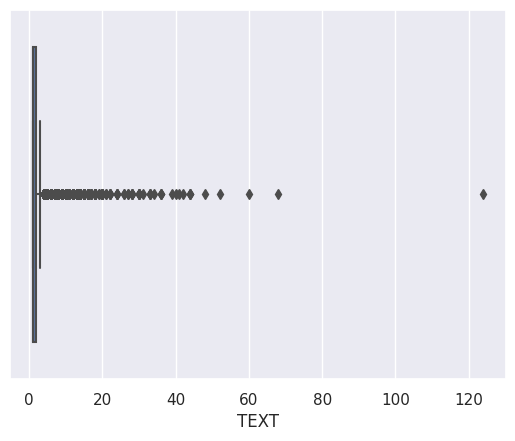

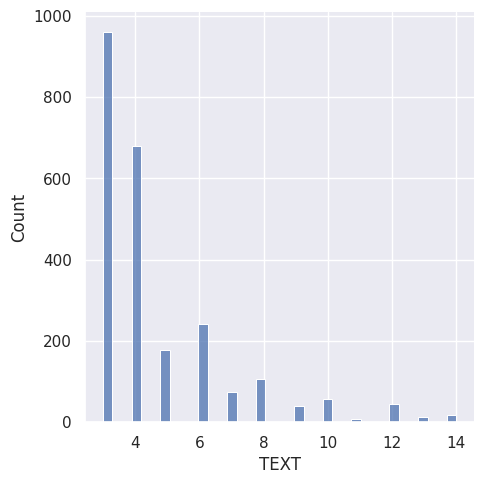

In [338]:
import seaborn as sns
sns.set()


gb_notes = deceased_TSICU.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()
print(num_notes)
print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<15))])

In [339]:
grouping = df_notes_TSICU.groupby(['CGID','SUBJECT_ID']).size()
df_notes_TSICU['num_of_notes'] = df_notes_TSICU.set_index(['CGID','SUBJECT_ID']).index.map(grouping)
df_notes_TSICU_filtered = df_notes_TSICU[df_notes_TSICU['num_of_notes'] >= 4]
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18236 entries, 0 to 48115
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          18236 non-null  int64  
 1   SUBJECT_ID      18236 non-null  int64  
 2   CGID            18236 non-null  int64  
 3   CHARTDATE       18236 non-null  object 
 4   TEXT            18236 non-null  object 
 5   HADM_ID         18236 non-null  int64  
 6   ICUSTAY_ID      18236 non-null  int64  
 7   DBSOURCE        18236 non-null  object 
 8   FIRST_CAREUNIT  18236 non-null  object 
 9   LAST_CAREUNIT   18236 non-null  object 
 10  FIRST_WARDID    18236 non-null  int64  
 11  LAST_WARDID     18236 non-null  int64  
 12  INTIME          18236 non-null  object 
 13  OUTTIME         18236 non-null  object 
 14  LOS             18236 non-null  float64
 15  GENDER          18236 non-null  object 
 16  DOB             18236 non-null  object 
 17  DOD             10719 non-null 

In [340]:
df_notes_TSICU_filtered.head(10)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,...,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM,num_of_notes
0,1373553,8406,17765,2149-04-28,SOCIAL WORK NOTE:\n\nNew trauma pt on T-SICU f...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,11
1,1373550,8406,16140,2149-04-27,SICU NPN\nROS:\nNeuro: Neuro exam unchanged th...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,8
2,1373547,8406,16140,2149-04-26,"SICU NPN\nPt hemodynamicallly unstable today, ...",114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,8
3,1373567,8406,15659,2149-05-01,T/SICU NSG PROGRESS NOTE.\n0700>>[**2076**]\n\...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,4
4,1373633,8406,21570,2149-07-02,Nursing Progress Note.\n\nCV: The pt has been ...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,13
6,1373595,8406,16140,2149-05-09,SICU NPN\nPt remains in the ICU s/p MVC on [**...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,8
7,1373584,8406,16140,2149-05-06,SICU NPN\nROS:\nNeuro: Pt opens eyes inconsist...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,8
8,1373638,8406,21570,2149-07-04,PMICU Nursing Progress Note 7p-7a\nEvents\n\n ...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,13
9,1373604,8406,18078,2149-05-13,TRAUMA ICU NURSING PROGRESS NOTE\n\nREVIEW OF ...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,10
10,1373560,8406,16140,2149-04-30,SICU NPN\nPt remains critically ill s/p MVC\n\...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,80135,1,8


Filter by number of notes

number of notes: min=2, max=999, mean=47.0,  median=20.0


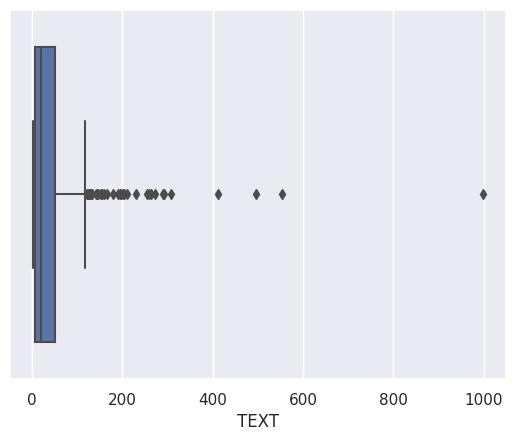

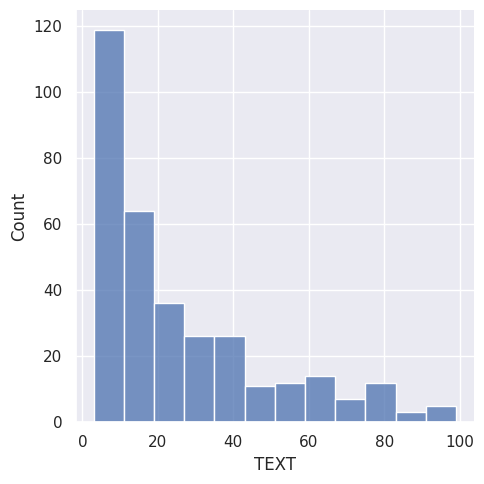

In [341]:
gb_notes = df_notes_TSICU_filtered.groupby(['ICD9_CODE'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<100))])

In [342]:
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18236 entries, 0 to 48115
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          18236 non-null  int64  
 1   SUBJECT_ID      18236 non-null  int64  
 2   CGID            18236 non-null  int64  
 3   CHARTDATE       18236 non-null  object 
 4   TEXT            18236 non-null  object 
 5   HADM_ID         18236 non-null  int64  
 6   ICUSTAY_ID      18236 non-null  int64  
 7   DBSOURCE        18236 non-null  object 
 8   FIRST_CAREUNIT  18236 non-null  object 
 9   LAST_CAREUNIT   18236 non-null  object 
 10  FIRST_WARDID    18236 non-null  int64  
 11  LAST_WARDID     18236 non-null  int64  
 12  INTIME          18236 non-null  object 
 13  OUTTIME         18236 non-null  object 
 14  LOS             18236 non-null  float64
 15  GENDER          18236 non-null  object 
 16  DOB             18236 non-null  object 
 17  DOD             10719 non-null 

In [343]:
drg_grouping = df_notes_TSICU_filtered.groupby(['ICD9_CODE']).size()
df_notes_TSICU_filtered['num_of_conditions'] = df_notes_TSICU_filtered.set_index(['ICD9_CODE']).index.map(drg_grouping)
#df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 1000)]
#df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 100)]
df_notes_TSICU_filtered.info()

<ipython-input-343-e4bb2933632b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notes_TSICU_filtered['num_of_conditions'] = df_notes_TSICU_filtered.set_index(['ICD9_CODE']).index.map(drg_grouping)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18236 entries, 0 to 48115
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             18236 non-null  int64  
 1   SUBJECT_ID         18236 non-null  int64  
 2   CGID               18236 non-null  int64  
 3   CHARTDATE          18236 non-null  object 
 4   TEXT               18236 non-null  object 
 5   HADM_ID            18236 non-null  int64  
 6   ICUSTAY_ID         18236 non-null  int64  
 7   DBSOURCE           18236 non-null  object 
 8   FIRST_CAREUNIT     18236 non-null  object 
 9   LAST_CAREUNIT      18236 non-null  object 
 10  FIRST_WARDID       18236 non-null  int64  
 11  LAST_WARDID        18236 non-null  int64  
 12  INTIME             18236 non-null  object 
 13  OUTTIME            18236 non-null  object 
 14  LOS                18236 non-null  float64
 15  GENDER             18236 non-null  object 
 16  DOB                182

In [344]:
df_notes_TSICU_dropped_cols = df_notes_TSICU_filtered.drop(['FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID','LAST_WARDID','INTIME', 'OUTTIME', 'DBSOURCE','DOB','DOD','DOD_HOSP','DOD_SSN','CHARTDATE'], axis=1)
df_notes_TSICU_dropped_cols.head(10)

,ROW_ID,SUBJECT_ID,CGID,TEXT,HADM_ID,ICUSTAY_ID,LOS,GENDER,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM,num_of_notes,num_of_conditions
0,1373553,8406,17765,SOCIAL WORK NOTE:\n\nNew trauma pt on T-SICU f...,114444,239553,26.6668,F,1,80135,1,11,59
1,1373550,8406,16140,SICU NPN\nROS:\nNeuro: Neuro exam unchanged th...,114444,239553,26.6668,F,1,80135,1,8,59
2,1373547,8406,16140,"SICU NPN\nPt hemodynamicallly unstable today, ...",114444,239553,26.6668,F,1,80135,1,8,59
3,1373567,8406,15659,T/SICU NSG PROGRESS NOTE.\n0700>>[**2076**]\n\...,114444,239553,26.6668,F,1,80135,1,4,59
4,1373633,8406,21570,Nursing Progress Note.\n\nCV: The pt has been ...,114444,239553,26.6668,F,1,80135,1,13,59
6,1373595,8406,16140,SICU NPN\nPt remains in the ICU s/p MVC on [**...,114444,239553,26.6668,F,1,80135,1,8,59
7,1373584,8406,16140,SICU NPN\nROS:\nNeuro: Pt opens eyes inconsist...,114444,239553,26.6668,F,1,80135,1,8,59
8,1373638,8406,21570,PMICU Nursing Progress Note 7p-7a\nEvents\n\n ...,114444,239553,26.6668,F,1,80135,1,13,59
9,1373604,8406,18078,TRAUMA ICU NURSING PROGRESS NOTE\n\nREVIEW OF ...,114444,239553,26.6668,F,1,80135,1,10,59
10,1373560,8406,16140,SICU NPN\nPt remains critically ill s/p MVC\n\...,114444,239553,26.6668,F,1,80135,1,8,59


Inverse Document Frequency

In [345]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_notes_TSICU['TEXT'])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_score_dict = dict(zip(feature_names, tfidf_scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

top_words = sorted_words[:50]

In [346]:
print("Rank\tWord\t\t\tCount")
for rank, (word, score) in enumerate(top_words, start=1):
  print(f"{rank}\t{word.ljust(20)}\t{score}")

Rank	Word			Count
1	pt                  	3858.6903894773063
2	hr                  	1471.2297840163699
3	pain                	1164.7940882023252
4	remains             	1117.4422691304098
5	cont                	1066.8040470247722
6	ni                  	1064.6198456445684
7	clear               	1048.9647714021378
8	resp                	1043.7994178985034
9	neuro               	1034.6946010578495
10	plan                	1028.8010630778817
11	given               	1027.1312818576973
12	today               	1025.5294101764573
13	noted               	1000.4239611589724
14	skin                	998.9591517978236
15	care                	981.4243721169338
16	bs                  	980.788033148711
17	stable              	963.3350924689581
18	family              	932.8899041885581
19	intact              	924.446573253051
20	abd                 	916.9799870140846
21	vent                	901.7520471082976
22	100                 	875.3529533254995
23	monitor             	868.2895431277627
24	secretions 

select emotional words then filter rows that dont have a minimum number of them

In [347]:
selected_words = ['pain', 'family', 'stable', 'care', 'well', 'social', 'support', 'able', 'decreased', 'warm', 'unable', 'strong', 'intact', 'good', 'times', 'aware', 'eyes', 'tolerated', 'denies', 'tolerating', 'please', 'palpable']
print("selected_words list length: ", len(selected_words))
pattern = '|'.join(selected_words)
filtered_data = df_notes_TSICU_dropped_cols[df_notes_TSICU_dropped_cols['TEXT'].str.contains(pattern, regex=True)].copy()
#filtered_data = df_notes_TSICU[df_notes_TSICU['TEXT'].str.contains(pattern, regex=True)].copy()
filtered_data['num_search_words'] = filtered_data['TEXT'].str.count(pattern)
filtered_data = filtered_data[filtered_data['num_search_words'] >= 5]
filtered_data.info()

selected_words list length:  22
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9085 entries, 0 to 48112
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             9085 non-null   int64  
 1   SUBJECT_ID         9085 non-null   int64  
 2   CGID               9085 non-null   int64  
 3   TEXT               9085 non-null   object 
 4   HADM_ID            9085 non-null   int64  
 5   ICUSTAY_ID         9085 non-null   int64  
 6   LOS                9085 non-null   float64
 7   GENDER             9085 non-null   object 
 8   EXPIRE_FLAG        9085 non-null   int64  
 9   ICD9_CODE          9085 non-null   object 
 10  SEQ_NUM            9085 non-null   int64  
 11  num_of_notes       9085 non-null   int64  
 12  num_of_conditions  9085 non-null   int64  
 13  num_search_words   9085 non-null   int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 1.0+ MB


Random selection from sample set

In [370]:
random_filtered_data = filtered_data.sample(n=1000, random_state=42)

Remove similar sentences

In [371]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sentences = random_filtered_data['TEXT'].tolist()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)
similarity_threshold = 0.8

similar_indices = []
for i, sentence in enumerate(sentences):  # needs to be max 1000 entries
  if any(cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0] > similarity_threshold for j in range(i)):  # very slow ~10 minutes for 1000 entries, exponential complexity (more than 5 hours if 6000 entries)
    similar_indices.append(i)

In [372]:
index_labels = random_filtered_data.index[similar_indices]
random_filtered_data.drop(index_labels, inplace=True)

random_filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966 entries, 35075 to 8537
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             966 non-null    int64  
 1   SUBJECT_ID         966 non-null    int64  
 2   CGID               966 non-null    int64  
 3   TEXT               966 non-null    object 
 4   HADM_ID            966 non-null    int64  
 5   ICUSTAY_ID         966 non-null    int64  
 6   LOS                966 non-null    float64
 7   GENDER             966 non-null    object 
 8   EXPIRE_FLAG        966 non-null    int64  
 9   ICD9_CODE          966 non-null    object 
 10  SEQ_NUM            966 non-null    int64  
 11  num_of_notes       966 non-null    int64  
 12  num_of_conditions  966 non-null    int64  
 13  num_search_words   966 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 113.2+ KB


Find matching conditions for both expired flags

In [373]:
random_filtered_data['EXPIRE_FLAG'] = random_filtered_data['EXPIRE_FLAG'].astype(int)
group_conditions = random_filtered_data.groupby(['ICD9_CODE', 'EXPIRE_FLAG'])
def balance_conditions(g1,g2,size):
  size = min(len(g1), len(g2), size)
  return g1.sample(n=size, random_state=1), g2.sample(n=size, random_state=1)

rows = []
size = 200

for drg_desc, group in group_conditions:
  icd9, expire = drg_desc
  if (icd9, 1-expire) in group_conditions.groups:
    paired_group = group_conditions.get_group((icd9, 1-expire))
    group_sample1, group_sample2 = balance_conditions(group, paired_group, size)
    rows.append(group_sample1)
    rows.append(group_sample2)
    size -= len(group_sample1)
  if size <= 0:
    break

balanced_data = pd.concat(rows)
balanced_data = balanced_data.drop_duplicates()

balanced_data.info()
print(balanced_data[['ICD9_CODE', 'EXPIRE_FLAG']])

#valid_groups = [key for key, group in group_conditions.groups.keys() if (key[0], key[1], 1 - key[2]) in group_conditions.groups]
#for key in valid_groups:
  #pass

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 4214 to 7041
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             200 non-null    int64  
 1   SUBJECT_ID         200 non-null    int64  
 2   CGID               200 non-null    int64  
 3   TEXT               200 non-null    object 
 4   HADM_ID            200 non-null    int64  
 5   ICUSTAY_ID         200 non-null    int64  
 6   LOS                200 non-null    float64
 7   GENDER             200 non-null    object 
 8   EXPIRE_FLAG        200 non-null    int64  
 9   ICD9_CODE          200 non-null    object 
 10  SEQ_NUM            200 non-null    int64  
 11  num_of_notes       200 non-null    int64  
 12  num_of_conditions  200 non-null    int64  
 13  num_search_words   200 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 23.4+ KB
      ICD9_CODE  EXPIRE_FLAG
4214       0389            0
4

Seperate deceased and living

In [352]:
deceased_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 1]
deceased_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 4344 to 14167
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             44 non-null     int64  
 1   SUBJECT_ID         44 non-null     int64  
 2   CGID               44 non-null     int64  
 3   TEXT               44 non-null     object 
 4   HADM_ID            44 non-null     int64  
 5   ICUSTAY_ID         44 non-null     int64  
 6   LOS                44 non-null     float64
 7   GENDER             44 non-null     object 
 8   EXPIRE_FLAG        44 non-null     int64  
 9   ICD9_CODE          44 non-null     object 
 10  SEQ_NUM            44 non-null     int64  
 11  num_of_notes       44 non-null     int64  
 12  num_of_conditions  44 non-null     int64  
 13  num_search_words   44 non-null     int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 5.2+ KB


In [353]:
living_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 0]
living_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 39780 to 1561
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             44 non-null     int64  
 1   SUBJECT_ID         44 non-null     int64  
 2   CGID               44 non-null     int64  
 3   TEXT               44 non-null     object 
 4   HADM_ID            44 non-null     int64  
 5   ICUSTAY_ID         44 non-null     int64  
 6   LOS                44 non-null     float64
 7   GENDER             44 non-null     object 
 8   EXPIRE_FLAG        44 non-null     int64  
 9   ICD9_CODE          44 non-null     object 
 10  SEQ_NUM            44 non-null     int64  
 11  num_of_notes       44 non-null     int64  
 12  num_of_conditions  44 non-null     int64  
 13  num_search_words   44 non-null     int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 5.2+ KB


Display notes

In [354]:
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_rows', None)
#print(balanced_data['TEXT'].head(200))
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

In [355]:
#print(balanced_data.head(200))

Save to CSV

In [374]:
# path and name of the cvs file 
PATH_TO_SAVE = "/content/drive/MyDrive/NIH/Data/"
name_file_to_save = 'NOTES_NURSING_TRAJECTORIES_TSICU.csv'
balanced_data.to_csv(PATH_TO_SAVE+name_file_to_save,index=False)

Tokenized words

In [357]:
#text = df_notes_TSICU['TEXT'].str.cat(sep=' ')
#words = nltk.word_tokenize(text)  # very slow

Count words in notes

In [358]:
#stopwords = nltk.corpus.stopwords.words('english')
#words = [word.lower() for word in words if word.lower() not in stopwords and re.match(r'\b\w+\b', word)]  # also slow but only kinda slow
#word_counts = Counter(words)
#most_common_words = word_counts.most_common(300)

In [359]:
#print("Rank\tWord\t\t\tCount")
#for rank, word_count in enumerate(most_common_words, start=1):
  #word, count = word_count
  #print(f"{rank}\t{word.ljust(20)}\t{count}")

Emotional words

In [360]:
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #synsets = wn.synsets(word)
  #if synsets:
    #senti_synset = swn.senti_synset(synsets[0].name())
    #if senti_synset.pos_score() > 0.45 or senti_synset.neg_score() > 0.45:
      #emotional_words.append(word)

#emotional_words

In [361]:
#from textblob import TextBlob
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #tb = TextBlob(word)
  #sentiment = tb.sentiment.polarity
  #if abs(sentiment) > 0.35:
    #emotional_words.append(word)

#emotional_words